### Agents (Do Math)

In [1]:
from dotenv import load_dotenv,find_dotenv
import os
env_path = find_dotenv(filename='password.env',usecwd=True)
load_dotenv(env_path)

True

In [2]:
key = os.getenv('OPENAI_API_KEY')

In [37]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
import math

model = ChatOpenAI(model='gpt-4o-mini', api_key = key)

@tool
def calculate_rectangle_area(a:float,b:float)-> float:
    """This function calculates the area of a rectangle in square feet given the length of sides a and b"""

    return a*b

tools = [calculate_rectangle_area]
agent = create_react_agent(model,tools)

query = "calculate the area of a reactangular room with sides 15.2 and 10"

response = agent.invoke({'messages':[('human',query)]})

print(response["messages"][-1].content)

C:\Users\gaura\AppData\Local\Temp\ipykernel_33188\664160286.py:15: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(model,tools)


The area of the rectangular room with sides 15.2 feet and 10 feet is 152 square feet.


In [38]:
from langchain_core.messages import HumanMessage,AIMessage
message_history = response['messages']

new_query = "What is the area of a rectangle with sides 78 and 26"

response = agent.invoke({'messages':message_history+[('human',new_query)]})

history = [msg for msg in response['messages'] if isinstance(msg,(HumanMessage,AIMessage)) and msg.content.strip()]



In [39]:
for msg in history:
    role = msg.type
    content = msg.content
    print(role,'\n',content)

human 
 calculate the area of a reactangular room with sides 15.2 and 10
ai 
 The area of the rectangular room with sides 15.2 feet and 10 feet is 152 square feet.
human 
 What is the area of a rectangle with sides 78 and 26
ai 
 The area of the rectangle with sides 78 feet and 26 feet is 2028 square feet.


In [ ]:
for msg in message_history:
    role = msg.type  # 'human', 'ai', 'tool', 'system'
    content = getattr(msg, "content", "")
    print(f"{role.upper()}: {content}\n")

HUMAN: What is the area of 10 by 12?

AI: 

TOOL: 120.0

AI: The area of a rectangle measuring 10 by 12 is 120 square feet.

HUMAN: What about one with sides 4 and 3?

AI: 

TOOL: 12.0

AI: The area of a rectangle with sides measuring 4 and 3 is 12 square feet.



### Building chatbots with langgraph
> Agent states and Graph states. *Graph state* organizes tool use and LLM calls into a work flow. *Agent state* tracks the agents progress as text
> *Langgraph* is organized into nodes and edges. Nodes represent different tools/functions and or actions. *Edges* represent control flow/connections between the nodes.

There are some key elements to building a chatbot/agentic workflow
* You need to define an llm for use
* You need to define a State class that records the state of the system
* You need to build a graph with nodes defined and the edges connecting the nodes

In [47]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

#Define an llm
llm = ChatOpenAI(model='gpt-4o-mini', api_key=key)

#Define a class State to record the state of the system

class State(TypedDict):
    messages: Annotated[list,add_messages]

#Intialize graph
graph_builder = StateGraph(State)

def chatbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}

#Now add nodes and edges
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile()

def stream_graph_updates(user_input:str):
    for event in graph.stream({'messages':[('user',user_input)]}):
        for value in event.values():
            print("Agent",value['messages'])

print(stream_graph_updates('Who is Gauss?'))


Agent [AIMessage(content="Carl Friedrich Gauss (1777–1855) was a German mathematician, astronomer, and physicist who is often referred to as one of the greatest mathematicians of all time. His contributions span a wide range of fields, including number theory, statistics, analysis, differential geometry, geophysics, electrostatics, astronomy, and many others.\n\nSome of his notable achievements and contributions include:\n\n1. **Number Theory**: Gauss wrote *Disquisitiones Arithmeticae*, a foundational text in number theory that introduced concepts such as congruences and the distribution of prime numbers.\n\n2. **Gaussian Distribution**: In statistics, the normal distribution is sometimes referred to as the Gaussian distribution in his honor. It describes how values of a variable are distributed in many natural phenomena.\n\n3. **Gaussian Elimination**: A method for solving systems of linear equations, which is widely used in various applied fields.\n\n4. **Fundamental Theorem of Alge

In [50]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

llm = ChatOpenAI(model='gpt-4o-mini', api_key=key)

class State(TypedDict):
    messages: Annotated[list,add_messages]

def chatbot(state:State):
    return {'messages':llm.invoke(state['messages'])}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile()

def stream_graph_events(user_input:str):
    for event in graph.stream({'messages':[('user',user_input)]}):
        for item in event.values():
            print("Agent",item['messages'])

print(stream_graph_events('What is pi?'))

    

Agent content="Pi (π) is a mathematical constant that represents the ratio of a circle's circumference to its diameter. It is an irrational number, meaning that it cannot be expressed as a simple fraction and its decimal representation goes on infinitely without repeating. The approximate value of pi is 3.14159, but it is often rounded to 3.14 for simplicity in calculations. Pi is used in various areas of mathematics and physics, especially in calculations involving circles, spheres, and periodic phenomena. It plays a crucial role in geometry, trigonometry, and calculus." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 11, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_

### Adding tools to agents
* Tools with API capibilities help augment chatbot agents by enabling access to external sources
* When you add an external tool you need to 
    * Bind the tool to the llm (create *llm_with_tools*)
    * Change the chatbot function to incorporate the *llm_with_tools*
    * Define and add a tools node
    * Add a congitional edge connecting chatbot node to the *tools_condition*. This will let the chatbot decide if the tool is needed

In [ ]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# Define the LLM
llm = ChatOpenAI(model='gpt-4o-mini',
                 api_key = key)

# Create the State Class
class State(TypedDict):
    messages : Annotated[list,add_messages]

# Define the wikipedia tool
wikipedia_wrapper = WikipediaAPIWrapper(k=1)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)
tools = [wikipedia_tool]

#Bind the tool with the llm
llm_with_tool = llm.bind_tools(tools)

# define the chatbot function (revidesd for tool calling)
# def chatbot(user_query:str):
#     return {'messages':llm_with_tool.invoke([state['messages']])}

def chatbot(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Start building the graph
graph_builder = StateGraph(State)
graph_builder.add_node(chatbot,"chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile()

def stream_tool_responses(user_input:str):
    for event in graph.stream({'messages':[('user',user_input)]}):
        for value in event.values():
            print("Agent",value['messages'])

user_input = "What is the normal distribution?"
stream_tool_responses(user_input)

Agent [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 87, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CuQhJCJuFRcpL88IIdQqPY9Y9BwJ7', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--6dcb6489-08c5-433d-adea-52013c316b18-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Normal Distribution'}, 'id': 'call_QiesI9g7kX7w02VPAnkiRwfV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 14, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
Agent [ToolMess

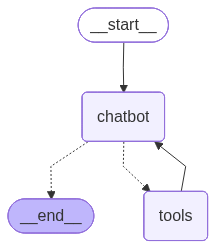

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Adding memory to a chat
* first import MemorySaver from langgraph.checkpoint.memory
* Instatntiate it
* When you compile the graph set checkpointer=memory

In [ ]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langgraph.graph import START,END,StateGraph


class State(TypedDict):

    messages: Annotated[list,add_messages]

llm = ChatOpenAI(model ='gpt-4o-mini',
                 api_key = key)

wikipedia_wrapper = WikipediaAPIWrapper(k=1)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)
tools = [wikipedia_tool]

llm_with_tool = llm.bind_tools(tools)

def chatbot(state:State):
    return {'messages':[llm_with_tool.invoke(state['messages'])]}




c:\Users\gaura\anaconda3\envs\langchain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
